In [4]:
from juxtorpus.corpus import Corpus
from juxtorpus.corpus.meta import SeriesMeta
import pandas as pd
import inspect

titles = pd.read_table("./topsbm/titles.txt", header=None)
corpus = Corpus.from_dataframe(pd.read_table("./topsbm/corpus.txt", header=None), col_doc=0)
corpus.add_meta(SeriesMeta(id_='title', series=titles.loc[:, 0]))
corpus.summary().T

,Name,Parent,Corpus Type,Number of Documents,Number of Total Words,Size of Vocabulary,mean Words per Document,min Words per Document,max Words per Document,metas
,fervent-fulmar,,Corpus,63,31208,3071,495,14,5265,title


In [5]:
texts = corpus.dtm.to_lists_of_terms()
len(texts)

63

In [6]:
import graph_tool.all as gt
from topsbm.sbmtm import sbmtm

model = sbmtm()

In [7]:
model.make_graph(texts, documents=corpus.meta['title'].series.tolist())

In [8]:
%%timeit -n 1 -r 1

## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

<NestedBlockState object, with base <BlockState object with 3134 blocks (61 nonempty), degree-corrected, for graph <Graph object, undirected, with 3134 vertices and 12060 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f7cc85da430>, at 0x7f7cec125160>, and 4 levels of sizes [(3134, 61), (61, 9), (9, 2), (2, 1)] at 0x7f7cd85cfe80>
5.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


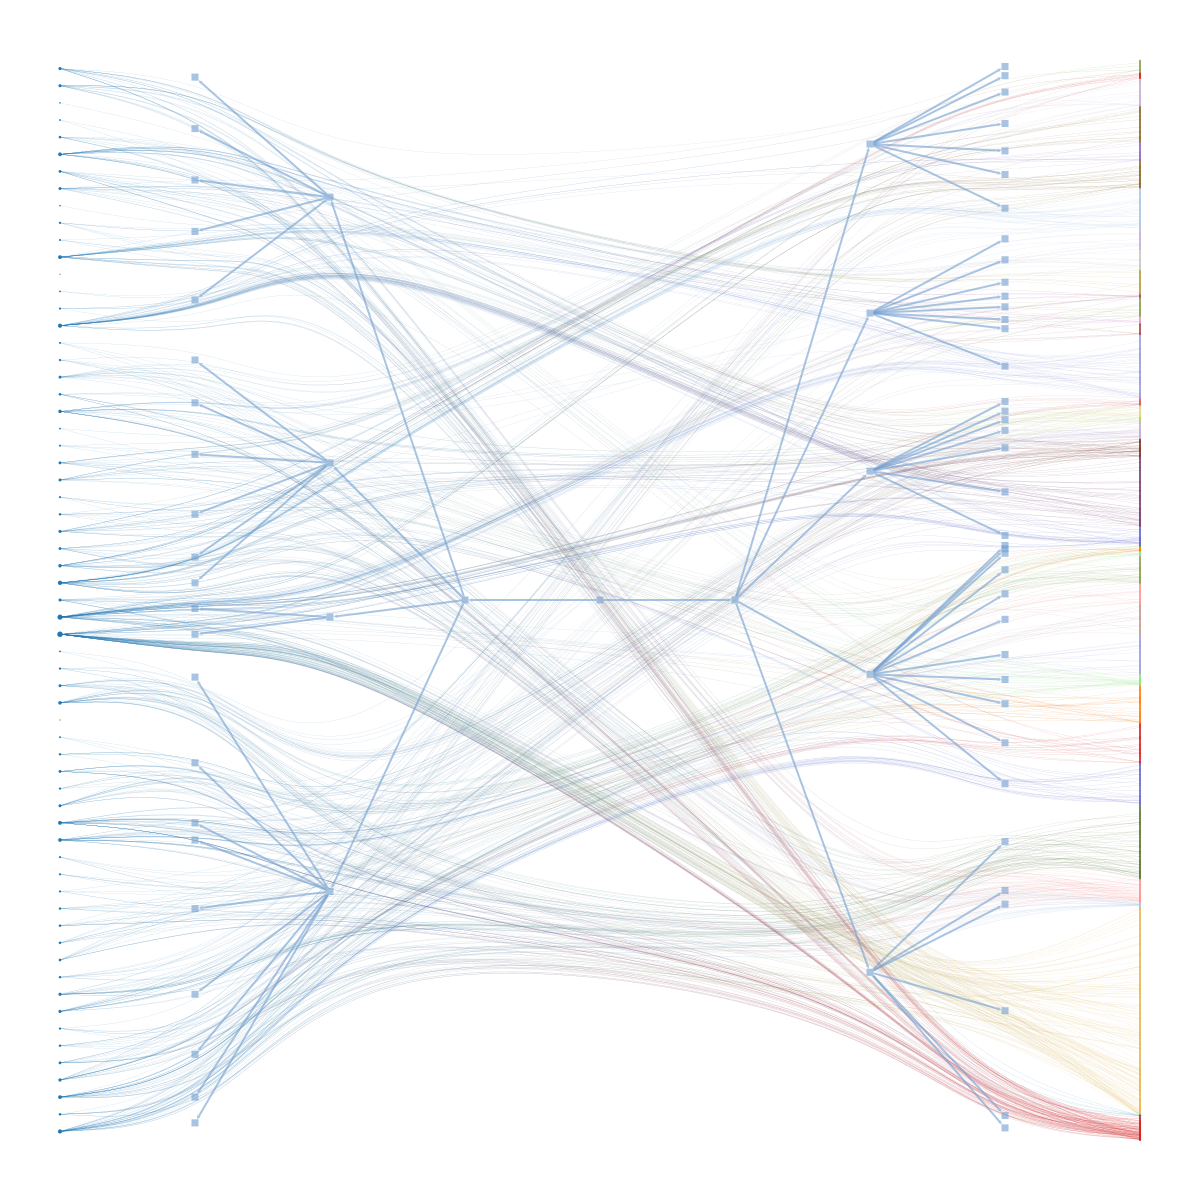

7.53 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n 1 -r 1

model.plot(nedges=1000)

In [19]:
model.topics(l=1,n=20).get(0)

[('the', 0.21773150983193848),
 ('and', 0.07634211063482343),
 ('for', 0.029121589440021772),
 ('that', 0.021977274273661293),
 ('are', 0.02102469891814656),
 ('with', 0.01667006872150779),
 ('this', 0.015173164591413213),
 ('can', 0.014084507042253521),
 ('which', 0.01394842484860856),
 ('from', 0.01306389058991631),
 ('used', 0.008232972715520174),
 ('not', 0.008096890521875212),
 ('has', 0.007960808328230252),
 ('such', 0.007280397360005443),
 ('these', 0.007076274069538001),
 ('other', 0.006599986391780635),
 ('have', 0.006531945294958155),
 ('two', 0.00612369871402327),
 ('also', 0.005851534326733347),
 ('may', 0.005647411036265905)]

In [27]:
# returns the topic distribution of the document 0.
sorted(model.topicdist(0), key=lambda t: t[1], reverse=True)

[(1, 0.2631578947368421),
 (2, 0.14035087719298245),
 (0, 0.10526315789473684),
 (8, 0.06578947368421052),
 (12, 0.06140350877192982),
 (10, 0.05263157894736842),
 (11, 0.043859649122807015),
 (9, 0.039473684210526314),
 (3, 0.03508771929824561),
 (6, 0.03070175438596491),
 (4, 0.02631578947368421),
 (13, 0.021929824561403508),
 (16, 0.017543859649122806),
 (15, 0.013157894736842105),
 (18, 0.013157894736842105),
 (20, 0.013157894736842105),
 (5, 0.008771929824561403),
 (19, 0.008771929824561403),
 (21, 0.008771929824561403),
 (22, 0.008771929824561403),
 (7, 0.0043859649122807015),
 (14, 0.0043859649122807015),
 (17, 0.0043859649122807015),
 (23, 0.0043859649122807015),
 (24, 0.0043859649122807015),
 (25, 0.0),
 (26, 0.0),
 (27, 0.0),
 (28, 0.0),
 (29, 0.0),
 (30, 0.0),
 (31, 0.0),
 (32, 0.0),
 (33, 0.0),
 (34, 0.0),
 (35, 0.0),
 (36, 0.0),
 (37, 0.0),
 (38, 0.0)]

In [13]:
node = 168
model.g.vp['name'][node], model.g.vp['kind'][node]

('distances', 1)

In [40]:
# document-word weight via edge
e = next(model.g.edges())
weight = model.g.ep['count'][e]
model.g.vp['name'][e.source()], f"-{weight}->", model.g.vp['name'][e.target()], 

('Nuclear_Overhauser_effect Chemical_physics', '-24->', 'the')

## Parallels of pLSI and mixed-membership SBM

In pLSI, we want infer the latent variable, topics, within the document term matrix.

we first formulate the joint distribution of $P(d, w)$ as
$$
P(d, w) = P(d)P(w|d)
$$

Let's add a latent variable $z$ to represent topics and decompose $P(w|d)$ to include $z$.

$$
P(d, w) = P(d)\sum P(w|z)P(z|d)
$$

**Our goal is to estimate $P(w|z)$ and $P(z|d)$ from the data.**

The data we have: documents and their word frequencies.
> With this data, we can get $P(d, w)$ which can be represented as a table (since it's discrete) using our document term matrix.

EM optimisation:
1. identify the model parameter we want to optimise for, here it's $z$.
2. formulate the equation with bayes theorem
$$
P(z|w, d) = \frac{P(w|z)P(z|d)P(d)}{\sum P(w|z,d)P(z|d)P(d)}
$$
This is the probability of $z$ given ***a*** particular $w$ and $d$.

3. So, $P(d)$ is a constant, meaning they factor each other out. Hence,

$$
P(z|w, d) = \frac{P(w|z)P(z|d)}{\sum P(w|z)P(z|d)}
$$


You might notice we don't have any of those terms on the right.
So we first begin with some initial estimates for $P(w|z)$ and $P(z|d)$.
Let's say these estimates are uniform, meaning for each topic, every word in the vocabulary is equally likely. And for each document, every topic is equally likely.
For each $z$, we compute $P(z|d) = 1/Z$ and $P(w|z) = 1/W$ for however many words are in that document.

Issue with Dirichlet Priors:
1. topics distribution in a document are not always unimodal or uniform. It can be bimodal.
2. words distribution in a topic are not always unimodal or uniform. First of all, the natural process of word distribution follows Zipf's law, which isn't modelled by Dirichlet. Second of all, there should be multiple words in which

TopSBM

Motivators & Advantages:
1. non-parametric
2. not constrained to having a dirichlet prior
3. shorter description length - less entropy in the system i.e. more predictable in general.
4. over LDA, for large number of texts, the dimensions for d, w, z are scaled up simultaneously.
    i. finite topics in the underlying data always lead to undersampling of the Dirichlet distribution.
    ii. LDA is redundant in the way it describes the data in this sparse regime.
5. automatic clustering of documents (in LDA, we only get distribution of topics for documents and distribution of words for topics; documents aren't clustered)

Limitations:
1. for small texts m < 10 tokens - 
2. still a bag-of-words approach meaning that the *ordering* of words do not matter.
3. 

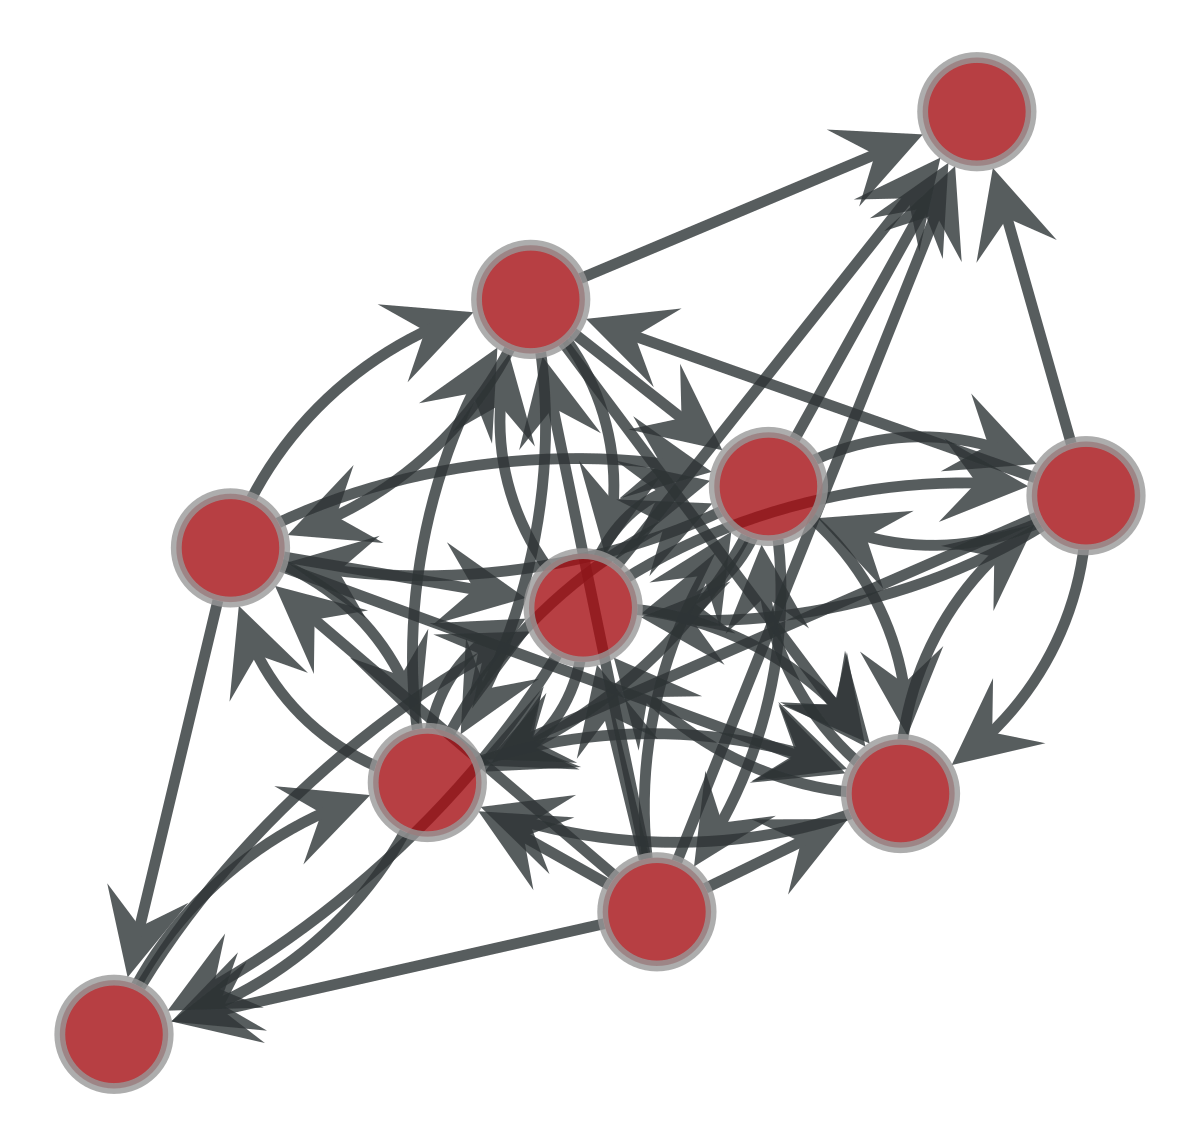

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7d09f422b0, at 0x7f7cdb0c03a0>

In [50]:
import graph_tool as gt
from graph_tool.all import *
import numpy as np

def deg_sampler() -> tuple[int, int]:
    in_deg = np.random.randint(0, 10)
    out_deg = np.random.randint(0, 10)
    return in_deg, out_deg

G = gt.generation.random_graph(10, deg_sampler=deg_sampler)
# graph_draw(G, pos=gt.draw.sfdp_layout(G))
graph_draw(G, pos=gt.draw.fruchterman_reingold_layout(G))

In [51]:
b=np.array([1, 2, 3]) # group membership for each node
probs = np.random.dirichlet(alpha=1,beta=1)
G = gt.generation.generate_sbm(b=b, pro
# graph_draw(G, pos=gt.draw.sfdp_layout(G))
graph_draw(G, pos=gt.draw.fruchterman_reingold_layout(G))

SyntaxError: positional argument follows keyword argument (2758240022.py, line 5)

In [59]:
np.random.dirichlet(alpha=[5, 5, 5], size=3)

array([[0.28948725, 0.23069655, 0.4798162 ],
       [0.33335547, 0.28503975, 0.38160478],
       [0.25297194, 0.30824993, 0.43877813]])